# Intro to filtering and time-series processing

[scipy ref page](https://docs.scipy.org/doc/scipy/reference/signal.html)

## Topic and basic principle of filtering
* Multiply FFT of timeseries by a transfer function, which is the FFT of time domain implementation of the filter
* basic demo of low pass, high pass, band pass and stop band filters implenmented in freq domain. 

## Imports

In [22]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from scipy import signal

# also define the default font we'll use for figures. 
fig_font = {'fontname':'Arial', 'size':'20'}

## Low pass filter
* Ideal low pass filter will only let through frequencies you want to keep and will truncate all high undesired high frequencies
* This will look like a step function in the frequency domain
* Take the followings steps to illustrate
    * Generate a complex signal that we can use for simulations
    * Make a step function filter in the frequency domain and see what happens...

In [227]:
# define a set of frequencies for our similated signal. 
# lets not add any IID noise yet so that the results turn out the same each time
Lf = 1  # lowest frequency
Hf = 16 # highest frequency

#generate list
frequs = np.linspace(Lf, Hf-1, Hf-Lf)
print(frequs)

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.]


In [228]:
# make our simulated signal
sr = 512                        # samp rate in Hz
tmax = 4                        # duration of signal, in s
dt = 1/sr                       # time step, reciprocal of the sr
t = np.arange(0,tmax,dt)        # time axis

# add up a bunch of sin waves at each of our desired frequencies
sig = np.zeros(len(t))
for f in np.arange(len(frequs)):
    sig = sig + np.sin(2*np.pi*frequs[f]*t)

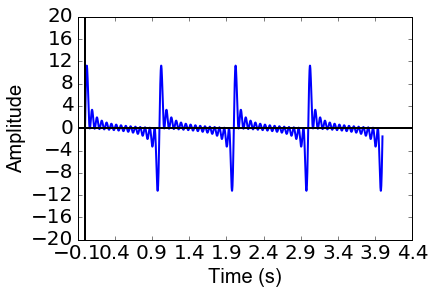

In [230]:
# Plot
plt.plot(t, sig, 'b-', linewidth = 2)    # specify x,y data...in this case time and amplitude of sin

# put some labels on the axes
plt.xlabel('Time (s)', **fig_font)
plt.ylabel('Amplitude', **fig_font)

# set the tick marks
plt.xticks(np.arange(-.1,tmax+.5,.5), color='k', size=20)
plt.yticks(np.linspace(-20,20,11), color='k', size=20)

# add some nice vertical/horizontal lines 
plt.axvline(0, color = 'k', linewidth = 2)
plt.axhline(0, color = 'k', linewidth = 2)

# show it
plt.show()

## Now FFT and lets have a look at the frequency spectrum 

In [327]:
# rfft = fft for real valued inputs
sp = np.fft.rfft(sig)   

# amplitude
amp = np.abs(sp)  

# normalize by the number of data points, 
# x2 cause we're ditching the negative frequencies when we deal with real numbers
amp = (amp  / len(sig) ) * 2   

# figure out the frequency resolution of the data 
freq = np.fft.rfftfreq(sig.size, dt)   # Sample spacing is 2nd arg, inverse of the sampling rate. Defaults to 1!

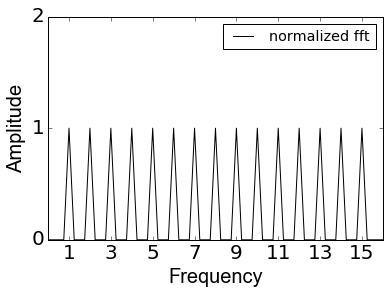

In [328]:
# plot the fft
plt.plot(freq, amp, 'k')            # plot amplitude 

# put a legend on it...
plt.legend(['normalized fft'], loc='best', fontsize='x-large')  
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.xticks(frequs[::2], color='k', size=20)
plt.yticks((0,1,2), color='k', size=20)

# set the axis limits
plt.xlim([0, Hf])

# show it
plt.show()

## Now design the perfect low pass filter - one that only passes frequencies below the cutoff and truncates everything else!
* Note that this will look like a box-car function in the frequency domain
* If you multiply this filter with the FFT of the original data, and then iFFT, you should only have low frequencies left!
* This kind of filter with a hard cutoff is often referred to as a brick-wall filter

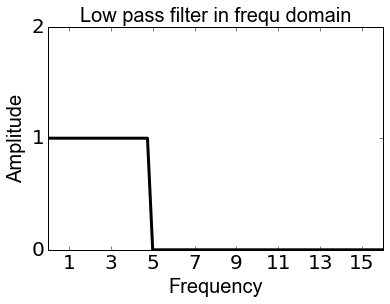

In [329]:
# lets pass everything blow 7Hz and cut off everything else
lowpass_cut = 5

# find the freq in our FFT range that is closest to our desired cutoff point
cutoff_pnt = np.argmin(np.abs(freq-lowpass_cut))

# make the filter
lp_filt = np.zeros(len(freq))
lp_filt[0:cutoff_pnt] = 1

plt.plot(freq, lp_filt, c='k', linewidth=3)
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.xticks(frequs[::2], color='k', size=20)
plt.yticks((0,1,2), color='k', size=20)
# set the axis limits
plt.xlim([0, Hf])
plt.title('Low pass filter in frequ domain', **fig_font)
plt.show()

## Apply the filtering by multiplying it with the data 
* To filter data, you can multiply the fft of your signal with the frequency domain representation of the filter...


In [331]:
# do the mutliplication in the frequ domain
# NEED THE COMPLEX VALUED SIGNAL, not just the amplitude
# so use sp, not amp

# filter the data (multiply, iFFT)
# do it in steps here to make it clear
multiply_in_frequ_domain = sp*lp_filt
# take the ifft
filtered_sig = np.fft.irfft(multiply_in_frequ_domain)

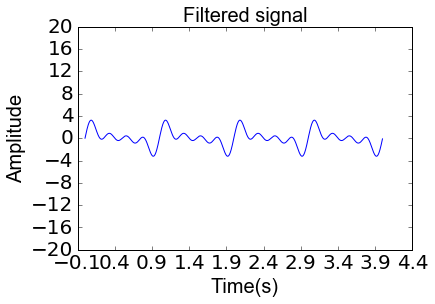

In [332]:
# plot the filtered data...all the high frequency stuff > 7Hz should be gone!
plt.plot(t, filtered_sig)
plt.xlabel('Time(s)', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.xticks(np.arange(-.1,tmax+.5,.5), color='k', size=20)
plt.yticks(np.linspace(-20,20,11), color='k', size=20)
plt.title('Filtered signal', **fig_font)
plt.show()

## Now lets FFT our filtered signal to see what it looks like in the frequ domain

In [333]:
# rfft = fft for real valued inputs
sp_filt = np.fft.rfft(filtered_sig)      
# amplitude
amp_filt = np.abs(sp_filt)  

# normalize by the number of data points, 
amp_filt = (amp_filt  / len(filtered_sig) ) * 2   

# figure out the frequency resolution of the data 
freq = np.fft.rfftfreq(filtered_sig.size, dt)   # Sample spacing is 2nd arg, inverse of the sampling rate. Defaults to 1!

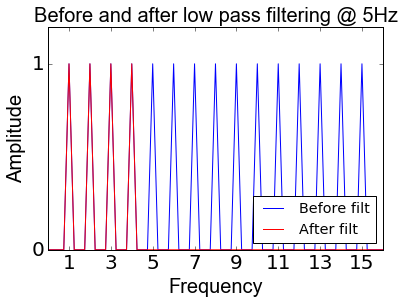

In [339]:
# plot the fft
plt.plot(freq, amp, 'b')            # plot amplitude of the original signal
plt.plot(freq, amp_filt, 'r')       # plot amplitude of filtered signal 

# put a legend on it...
plt.legend(['Before filt', 'After filt'], loc='best', fontsize='x-large')  
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.xticks(frequs[::2], color='k', size=20)
plt.yticks((0,1), color='k', size=20)

# set the axis limits
plt.xlim([0, Hf])

plt.title('Before and after low pass filtering @ 5Hz', **fig_font)

# show it
plt.show()

## What does that filter look like in the time domain?
* Inverse FFT the low-pass filter
* Its a sinc (cardinal sin) function

<div class="alert alert-info">
Notice that that the time-domain representation goes on forever in both directions...this is a problem for implementing with finite length data sets! We'll see how to address this below. 
</div>

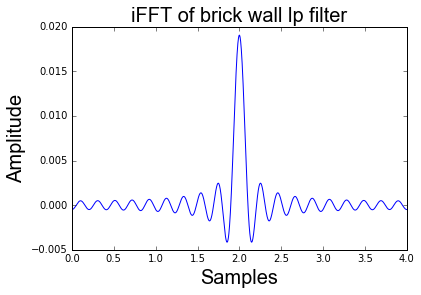

In [340]:
# iFFT
inv_filter = np.fft.irfft(lp_filt)

# symetric over the span, so center to better visualize
inv_filter = np.roll(inv_filter, int(len(inv_filter)/2))
plt.plot(t, inv_filter)
plt.xlabel('Samples', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.title('iFFT of brick wall lp filter', **fig_font)
plt.show()

## Now take a look at how to design this kind of filter in a more principled manner and deal with the infinite fall-off of the sinc for finite length data sets
* The iFFT of an ideal lp filter is a sinc function
* Can build the function in the time domain, then fft the filter and the signal, the multiply, then iFFT to get our filtered signal

### First make a slightly more interesting simulated signal to deal with...include a larger set of frequencies

In [432]:
# lets just pick a set of frequencies going from pretty low to higher than we had before
frequs = [5, 12, 17, 56]

In [433]:
# first lets set up a more interesting signal with some higher frequencies
sr = 512                        # samp rate in Hz
tmax = 4                        # duration of signal, in s
dt = 1/sr                       # time step, reciprocal of the sr
t = np.arange(0,tmax,dt)        # time axis

# add up a bunch of sin waves at each of our desired frequencies
sig = np.zeros(len(t))
for f in np.arange(len(frequs)):
    sig = sig + np.sin(2*np.pi*frequs[f]*t)

In [1]:
# Plot
plt.plot(t, sig, 'b-', linewidth = 2)    # specify x,y data...in this case time and amplitude of sin

# put some labels on the axes
plt.xlabel('Time (s)', **fig_font)
plt.ylabel('Amplitude', **fig_font)

# set the tick marks
plt.xticks(np.arange(-.1,tmax+.5,.5), color='k', size=20)
plt.yticks(np.linspace(-6,6,5), color='k', size=20)

# add some nice vertical/horizontal lines 
plt.axvline(0, color = 'k', linewidth = 2)
plt.axhline(0, color = 'k', linewidth = 2)

# show it
plt.show()

NameError: name 'plt' is not defined

### Now design our sinc filter!

In [502]:
# First specify a cutoff frequency, fc, that is a fraction of the sampling rate over 0, .5...why is the max .5?
fc = 0.1 

# Then specify the transition band, again this will be a fraction of the sampling rate over 0, .5
b = 0.1  

# more on this below, but now need to make sure that ceil(4/b) is odd
N = int(np.ceil((4 / b)))

# figure this out by returning the remainder (modulo operator) after dividing by 2
# if its even, then this == 0, else non-zero, so if its not true (i.e. == 0), then we add 1!
# if you don't do this then the function won't be centered
# An odd-length symmetrical filter will have delay that is an integer number of samples
# more on this in a bit...
if not N % 2: N += 1  
    
# generate span over which to eval sinc function    
n = np.arange(N)
 
# Compute the filter, taking into account our cutoff freq
sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
 
# Normalize to have an area of 1 (unit area)
sinc_func = sinc_func / np.sum(sinc_func)

## Plot the sinc function

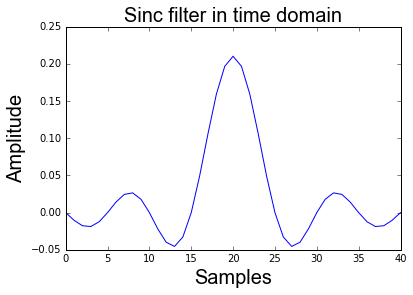

In [503]:
plt.plot(n, sinc_func)
plt.xlabel('Samples', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.title('Sinc filter in time domain', **fig_font)
plt.show()

## Now lets look at the frequency domain representation of this filter
* Remember that a sinc function goes on forever in both directions, and we've only evaluated it over a small range

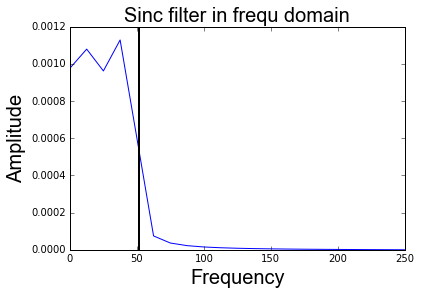

In [504]:
# take the fft, convert to amplitude, then normalize
sinc_fft = (np.abs(np.fft.rfft(sinc_func)) / len(filtered_sig) ) * 2

# figure out the frequency resolution of the data
# recall that our 'dt' here is calculated based on the signal 
# that we set up at the begining of the tutorial with a 
# sr = 512, so fc*512 should be around our filter fall-off
freq = np.fft.rfftfreq(sinc_func.size, dt)   

plt.plot(freq, sinc_fft)
plt.axvline(fc*sr, color = 'k', linewidth = 2)
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.title('Sinc filter in frequ domain', **fig_font)
plt.show()

### Note that it looks sort of like our brick wall filter, but the fall-off is not quite so sharp and there are weird bumps in it (esp in the low frequ part of the band)
* Our 'b' param will control the sharpness of the fall-off
* The bumps are the by-product of truncation a filter function that goes in both directions forever...
* Solution for the bumps is to apply a window that dampens the edge artifacts
    * A common choice - from among many - is a Blackman window 

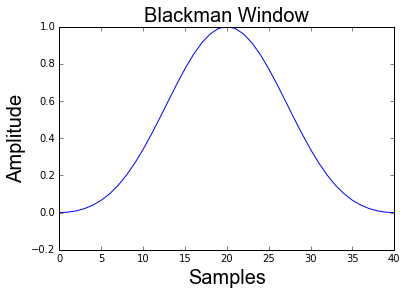

In [505]:
# build a Blackman window (by hand at first), take a look, and then apply to the filter and recompute everything
b_window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + \
    0.08 * np.cos(4 * np.pi * n / (N - 1))

# or, the boring way
# b_window = np.blackman(N)

plt.plot(n, b_window)
plt.xlabel('Samples', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.title('Blackman Window', **fig_font)
plt.show()

#### Apply the window to the sinc filter...
* Should dampend the edges while leaving the center of the filter unchanged

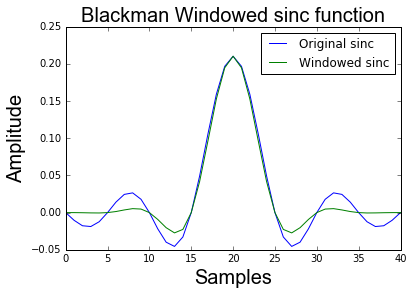

In [506]:
# element-wise multiplication
win_sinc_func = sinc_func * b_window
plt.plot(n, sinc_func)
plt.plot(n, win_sinc_func)
plt.legend(['Original sinc', 'Windowed sinc'])
plt.xlabel('Samples', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.title('Blackman Windowed sinc function', **fig_font)
plt.show()

#### Now lets have a look at the frequency domain representation of the windowed sinc function
* Should yeild a nice smooth function in the frequency domain!

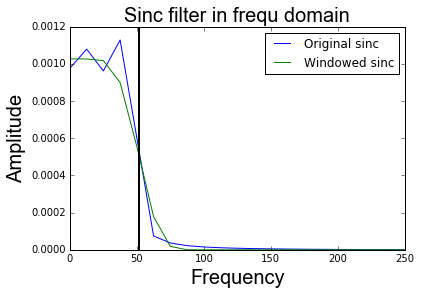

In [507]:
# take the fft, convert to amplitude, then normalize
win_sinc_fft = (np.abs(np.fft.rfft(win_sinc_func)) / len(filtered_sig) ) * 2

# figure out the frequency resolution of the data
# recall that our 'dt' here is calculated based on the signal 
# that we set up at the begining of the tutorial with a 
# sr = 512, so fc*512 should be around our filter fall-off
freq = np.fft.rfftfreq(win_sinc_func.size, dt)   

# plot
plt.plot(freq, sinc_fft)
plt.plot(freq, win_sinc_fft)
plt.legend(['Original sinc', 'Windowed sinc'])
plt.axvline(fc*sr, color = 'k', linewidth = 2)
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.title('Sinc filter in frequ domain', **fig_font)
plt.show()

## Now let's apply the windowed sinc function to the data to see how well it works.

In [508]:
# fft our signal
fft_sig = np.fft.rfft(sig)

# need to zero pad to make the filter the same length as the signal
X = len(sig)
Y = len(win_sinc_func)

# zero pad in the time domain
if Y<X:
    win_sinc_func = np.hstack((win_sinc_func, np.zeros(X-Y)))

# fft the filter
fft_filt = np.fft.rfft(win_sinc_func)

# multiply in freq domain, then ifft to go back into the time domain
filt_sig = np.fft.irfft(fft_sig*fft_filt)

In [2]:
# Plot the regular signal
plt.plot(t, sig)
plt.xlabel('Samples', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.title('Original Signal', **fig_font)
plt.show()

# plot the filtered signal
plt.plot(t, filt_sig)
plt.xlabel('Samples', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.title('Filtered Signal', **fig_font)
plt.show()

NameError: name 'plt' is not defined

## See how well we did - our filter should have cut off > 50Hz and left amp of frequencies lower than the cutoff relatively unchanged
* Notice that power at the 50Hz component of our signal is heavily attenuated!
* Go back and repeat with b = .01 - that will make the roll-off much sharper in the frequ domain (i.e. closer to a brick wall filter we started off with)

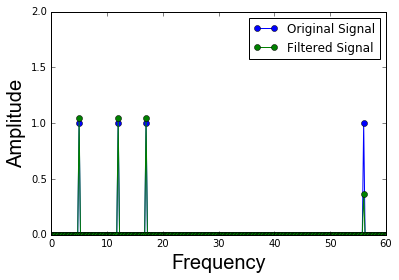

In [510]:
# fft our signal
fft_sig = (np.abs(np.fft.rfft(sig)) / len(sig) ) * 2
freq = np.fft.rfftfreq(sig.size, dt)   

# fft our filtered signal
fft_filt_sig = (np.abs(np.fft.rfft(filt_sig)) / len(filt_sig) ) * 2

# plot
plt.plot(freq, fft_sig, marker='o')
plt.plot(freq, fft_filt_sig, marker='o')
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.xlim([0, 60])
plt.ylim([0, 2])
plt.legend(['Original Signal', 'Filtered Signal'])
plt.show()

## So the filtering part works...however, if you plot the filtered signal on top of the original signal, you'll notice that there is a temporal shift that depends on the filter roll-off (b)
* The length of the filter is N, then we can correct for this by shifting by (N-1)/2

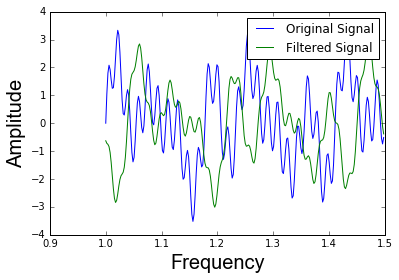

In [519]:
# to see this most clearly, lets just zoom in and plot a small segment of the data
# can do boolean indexing, but demo the "where" function here (like Matlab "find")
index = np.where((t>=1) & (t<1.5))

# plot
plt.plot(t[index], sig[index])
plt.plot(t[index], filt_sig[index])
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.legend(['Original Signal', 'Filtered Signal'])
plt.show()

### Notice that the filtered signal is low-pass filtered (smoother), but also shifted to the right in time.

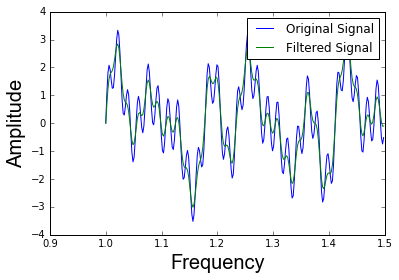

In [533]:
index = np.where((t>=1) & (t<1.5))
# shift by (N-1)/2 - this will be an integer so long as N is odd
# which is a condition that we enforced earlier when designing the 
# filter...shift by corresponding timepoints
shift_by = dt*((N-1)/2)  # convert to units of filter length in time: so number of points * dt
shift_index = np.where((t>=1+shift_by) & (t<1.5+shift_by))

# plot - should be all lined up!
plt.plot(t[index], sig[index])
plt.plot(t[index], filt_sig[shift_index])
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.legend(['Original Signal', 'Filtered Signal'])
plt.show()

## If all that makes sense, then we can easily use the same process to create a high-pass filter
* If you low-pass the data, then high frequencies are discarded and only low-frequs remain
* That means that the high frequency info in your data is equal to (original_signal - lp_filtered_signal)
* So if you have symetric filters, like our sinc functions, you can just invert it and you've got a high-pass filter that does the opposite of our low pass filter 